# Weather Preprocessing Notebook


### Importing libraries

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler



### Data formating

In [34]:

def format_climate(file_path):
    df = pd.read_csv(file_path)
    
    df.replace('-', pd.NA, inplace=True)
    df.dropna(inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

    df = df.drop(columns='Station')

    df['Total Rainfall Mm'] = pd.to_numeric(df['Total Rainfall Mm'], errors='coerce')
    df['Mean Air Temperature in Celsius'] = pd.to_numeric(df['Mean Air Temperature in Celsius'], errors='coerce')
    df['Mean Vapour Pressure Hpa'] = pd.to_numeric(df['Mean Vapour Pressure Hpa'], errors='coerce')
    df['Mean Wind Speed M/Sec'] = pd.to_numeric(df['Mean Wind Speed M/Sec'], errors='coerce')
    df['Days Of Wind Gust >= 24 Knots in Day'] = pd.to_numeric(df['Days Of Wind Gust >= 24 Knots in Day'], errors='coerce')
    df['Standard Deviation Of Daily Mean Temperature in Celsius'] = pd.to_numeric(df['Standard Deviation Of Daily Mean Temperature in Celsius'], errors='coerce')

    df_grouped = df.groupby('Date').mean().reset_index()

    return df_grouped

In [35]:
def format_eletricity_data(file_path):
    df = pd.read_csv(file_path)
    
    df['Period start'] = pd.to_datetime(df['Period start'], format='%d/%m/%y')
    

    df.dropna(inplace=True)

    return df

Read files

In [36]:
ElectricityDataBusiness_file = '../ElectricityData/Business_demand_trends_20240901140306.csv'
ElectricityDataResidential_file = '../ElectricityData/Residential_consumption_trends_20240901141207.csv'

climateData = format_climate('../ClimateDataProcessing/NewUpperNorthRegions.csv')
eletricityDataBusiness = format_eletricity_data(ElectricityDataBusiness_file)
eletricityDataResidential = format_eletricity_data(ElectricityDataResidential_file)


Visualise dataframes

In [37]:
eletricityDataBusiness.head()

,Period start,Period end,Region ID,Region description,Selected business demand (GWh),Regional demand (GWh),Proportion of regional demand (%),National demand (GWh),Proportion of national demand (%)
10,2010-01-01,31/01/10,CNI,Central North Island,502.788,692.117,72.6,3191.764,15.8
11,2010-02-01,28/02/10,CNI,Central North Island,475.792,649.906,73.2,3023.802,15.7
12,2010-03-01,31/03/10,CNI,Central North Island,539.230,734.442,73.4,3398.322,15.9
13,2010-04-01,30/04/10,CNI,Central North Island,505.722,707.522,71.5,3256.956,15.5
14,2010-05-01,31/05/10,CNI,Central North Island,519.263,757.412,68.6,3527.135,14.7


In [38]:
eletricityDataResidential.head()

,Period start,Period end,Region ID,Region,Est. Total consumption (GWh),Est. Total demand (GWh),Est. proportion of regional demand,Est. proportion of national demand,Average consumption (kWh),Average daily consumption (kWh),5th percentile (kWh),25th percentile (kWh),50th percentile (kWh),75th percentile (kWh),95th percentile (kWh),Coverage %
0,2010-01-01,31/01/10,CNI,Central North Island,177.005,189.329,27.355,5.932,487,15.7,119,279,430,624,1037,93.12
1,2010-02-01,28/02/10,CNI,Central North Island,162.780,174.114,26.791,5.758,447,16.0,118,259,396,570,944,93.08
2,2010-03-01,31/03/10,CNI,Central North Island,182.505,195.212,26.580,5.744,501,16.2,128,291,446,642,1060,93.11
3,2010-04-01,30/04/10,CNI,Central North Island,188.663,201.800,28.522,6.196,518,17.3,127,299,462,668,1103,93.27
4,2010-05-01,31/05/10,CNI,Central North Island,222.647,238.149,31.442,6.752,611,19.7,125,342,542,796,1336,93.18


In [39]:
climateData.head()

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month
0,2010-01-01,41.9,20.05,17.40,4.20,11.0,1.70,2010.0,1.0
1,2010-02-01,34.8,21.35,19.70,3.65,8.0,1.20,2010.0,2.0
2,2010-03-01,7.6,19.30,16.65,4.35,12.5,1.45,2010.0,3.0
3,2010-04-01,48.4,17.05,16.05,3.15,7.0,1.40,2010.0,4.0
4,2010-05-01,197.5,14.60,14.40,3.55,12.5,1.95,2010.0,5.0


Remove unnecessary columns

In [40]:
ElectricityDataBusiness_CNI = eletricityDataBusiness[eletricityDataBusiness['Region ID'] =='UNI']
ElectricityDataBusiness_CNI = ElectricityDataBusiness_CNI.drop(columns=[
    'Regional demand (GWh)',
    'Proportion of regional demand (%)', 
    'National demand (GWh)',
    'Proportion of national demand (%)'])


ElectricityDataResidential_CNI = eletricityDataResidential[eletricityDataResidential['Region ID'] =='UNI']
ElectricityDataResidential_CNI = ElectricityDataResidential_CNI.drop(columns=[
    'Est. Total demand (GWh)',
    'Est. proportion of regional demand',
    'Est. proportion of national demand', 'Average consumption (kWh)',
    'Average daily consumption (kWh)', '5th percentile (kWh)',
    '25th percentile (kWh)', '50th percentile (kWh)',
    '75th percentile (kWh)', '95th percentile (kWh)', 'Coverage %'])


Merge datasets by Dates and period start

In [41]:
# Merge Electricity Business Data
merged_data = climateData.merge(ElectricityDataBusiness_CNI, left_on='Date', right_on='Period start')
merged_data.drop(columns=['Period start', 'Period end', 'Region ID', 'Region description'], inplace=True)

# Merge Electricity Residential Data
merged_data = merged_data.merge(ElectricityDataResidential_CNI, left_on='Date', right_on='Period start')
merged_data.drop(columns=['Period start', 'Period end', 'Region ID', 'Region'], inplace=True)


Visualise dataframe

In [42]:
merged_data.head()

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
0,2010-01-01,41.9,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000
1,2010-02-01,34.8,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792
2,2010-03-01,7.6,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270
3,2010-04-01,48.4,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576
4,2010-05-01,197.5,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480


In [43]:
type(merged_data)

pandas.core.frame.DataFrame

### Visualise Data

In [44]:
merged_data.columns

Index(['Date', 'Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius', 'Year',
       'Month', 'Selected business demand (GWh)',
       'Est. Total consumption (GWh)'],
      dtype='object')

#### Climate Data

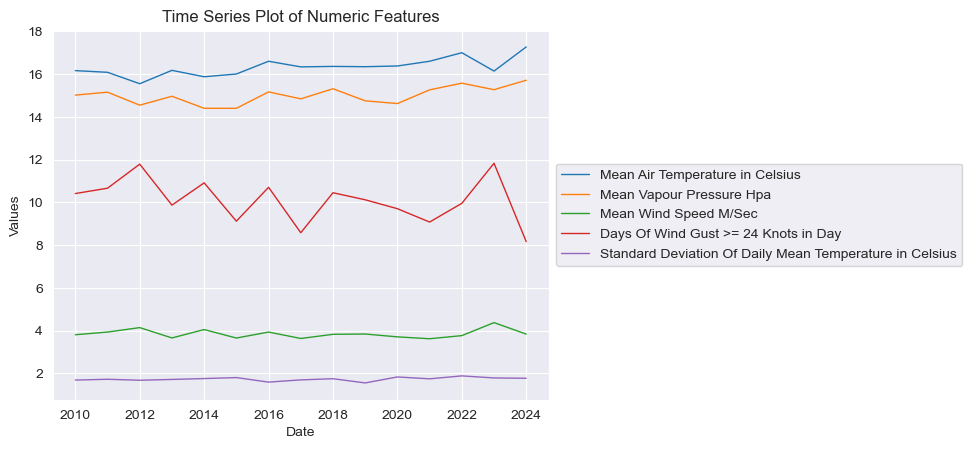

In [45]:
byyear = merged_data.groupby('Year').mean().reset_index()

numeric_columns = ['Mean Air Temperature in Celsius', 
                   'Mean Vapour Pressure Hpa', 
                   'Mean Wind Speed M/Sec', 
                   'Days Of Wind Gust >= 24 Knots in Day', 
                   'Standard Deviation Of Daily Mean Temperature in Celsius']

byyear.plot(x='Year', y=numeric_columns, kind='line', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Plot of Numeric Features')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

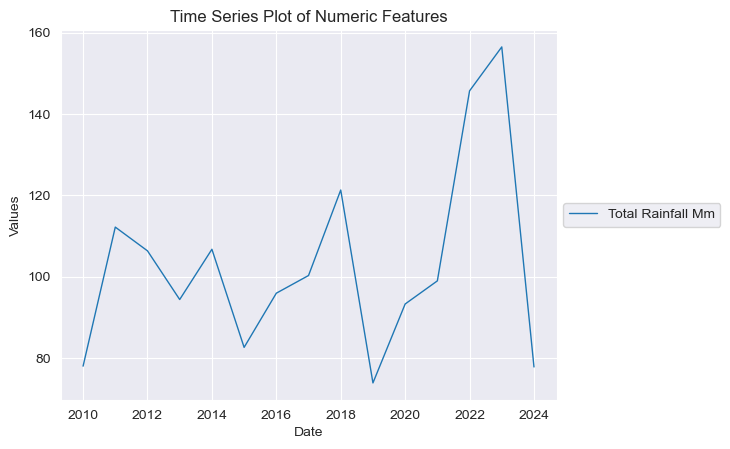

In [46]:
byyear.plot(x='Year', y='Total Rainfall Mm', kind='line', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Plot of Numeric Features')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Electricity Business Data

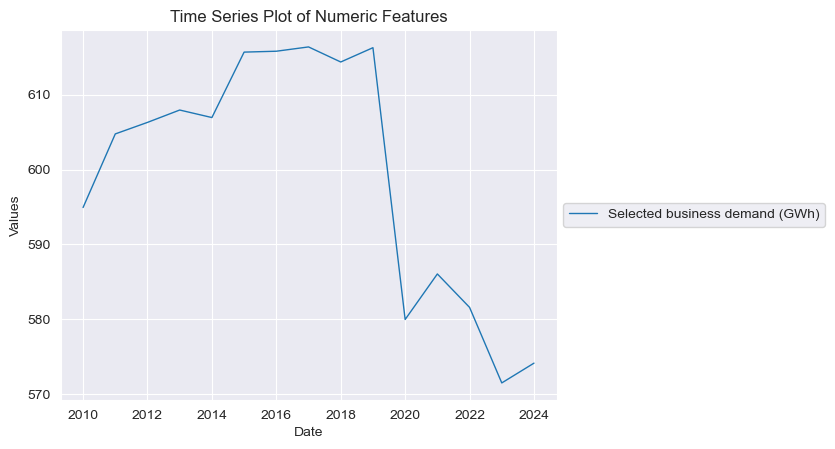

In [47]:
byyear = merged_data.groupby('Year').mean().reset_index()

byyear.plot(x='Year', y='Selected business demand (GWh)', kind='line', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Plot of Numeric Features')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Electricity Residential Data

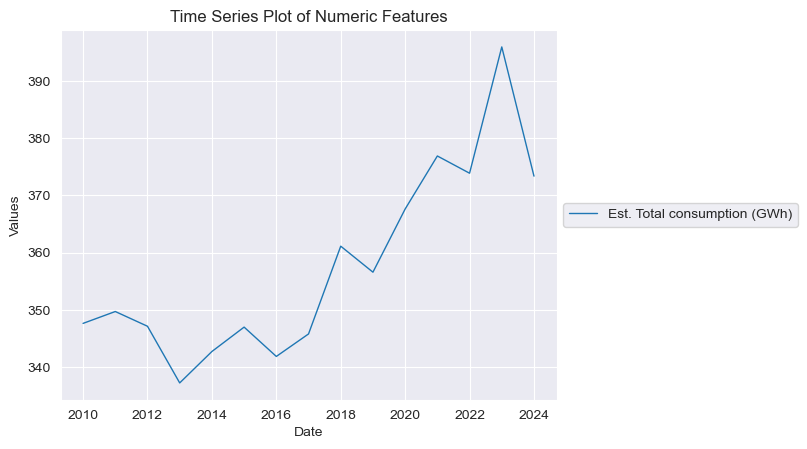

In [48]:
byyear = merged_data.groupby('Year').mean().reset_index()

byyear.plot(x='Year', y='Est. Total consumption (GWh)', kind='line', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Plot of Numeric Features')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Correlation visualisation

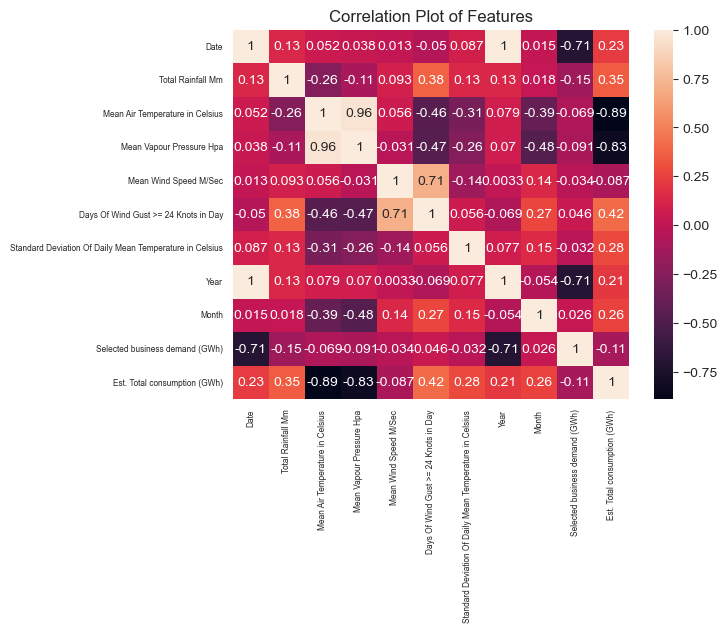

In [32]:
import seaborn as sns

correlation_matrix = merged_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Plot of Features')
plt.xticks(fontsize=6)  # set the x-axis tick font size
plt.yticks(fontsize=6)  # set the y-axis tick font size
plt.show()

#### Isolating to Business and Residential consumptions

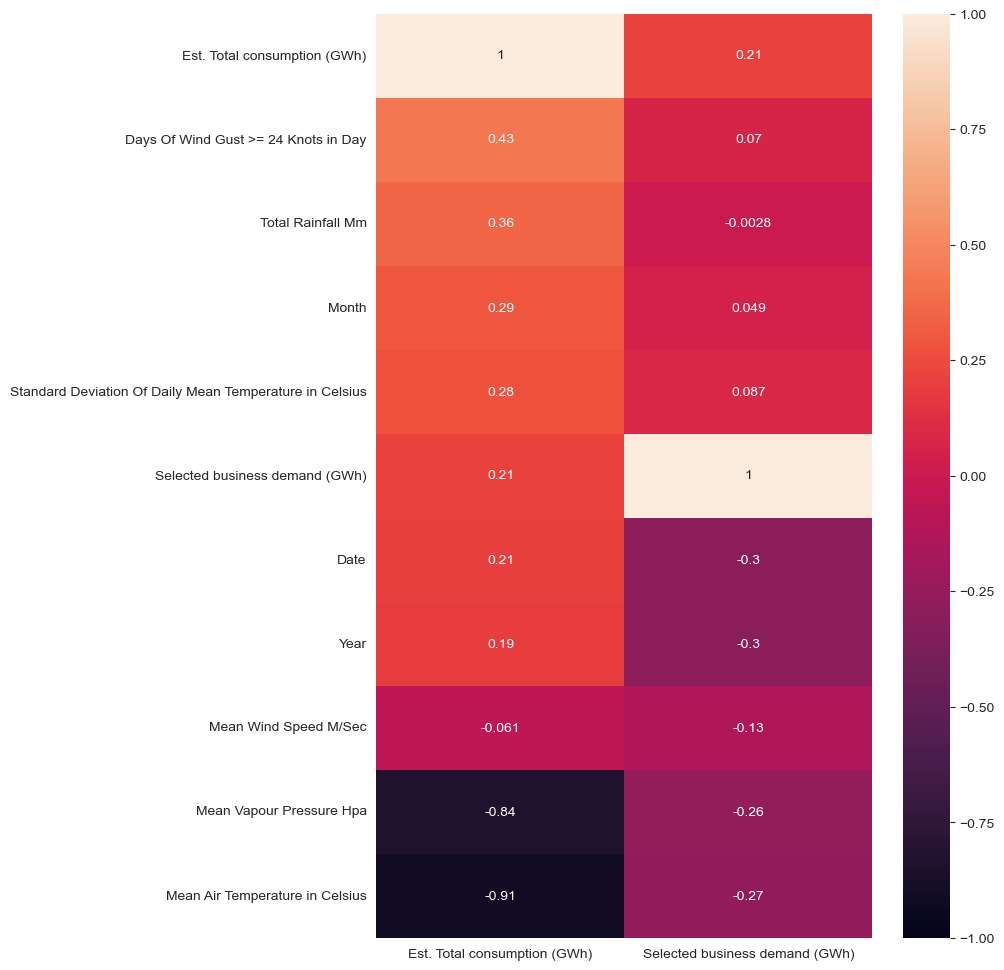

In [49]:
plt.figure(figsize=(8, 12))
heatmapTempHumidity = sns.heatmap(merged_data.corr()[['Est. Total consumption (GWh)',
       'Selected business demand (GWh)']].sort_values(by='Est. Total consumption (GWh)', ascending=False), vmin=-1, vmax=1, annot=True)



### Feature Selection Checking

In [19]:
def lasso_feature_selection(X, y, alpha):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    index = [i for i, coef in enumerate(lasso.coef_) if coef != 0]
    return lasso.coef_, X.columns[index]

In [20]:
def mi_feature_selection(X, y):
    mi = mutual_info_regression(X, y)
    return pd.DataFrame({'Feature': X.columns, 'MI Score': mi}).sort_values(by='MI Score', ascending=False)

In [21]:
def rfe_feature_selection(X, y, n_features):
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=n_features)
    selector = selector.fit(X, y)
    return selector.support_, X.columns[selector.support_]

In [22]:
x = merged_data[['Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius']]

yr = merged_data['Est. Total consumption (GWh)']
yb = merged_data['Selected business demand (GWh)']




In [23]:
coef, names = lasso_feature_selection(x, yr, 0.1)
print('Est. Total consumption (GWh)')
print('Coefficients:', coef.round(2))
print('Selected Features:', names)
print('----------------------------------------')

coef, names = lasso_feature_selection(x, yb, 0.1)
print('Selected business demand (GWh)')
print('Coefficients:', coef.round(2))
print('Selected Features:', names)
print('----------------------------------------')



Est. Total consumption (GWh)
Coefficients: [ -0.04 -18.89  11.    20.5   -0.65  -2.06]
Selected Features: Index(['Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius'],
      dtype='object')
----------------------------------------
Selected business demand (GWh)
Coefficients: [-1.000e-02  8.980e+00 -1.103e+01 -4.424e+01  3.210e+00  0.000e+00]
Selected Features: Index(['Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day'],
      dtype='object')
----------------------------------------


In [24]:
mi = mi_feature_selection(x, yr)
print('Est. Total consumption (GWh)')
print(mi)
print('----------------------------------------')

mi = mi_feature_selection(x, yb)
print('Selected business demand (GWh)')
print(mi)
print('----------------------------------------')


Est. Total consumption (GWh)
                                             Feature  MI Score
1                    Mean Air Temperature in Celsius  0.901969
2                           Mean Vapour Pressure Hpa  0.659550
4               Days Of Wind Gust >= 24 Knots in Day  0.195662
0                                  Total Rainfall Mm  0.098973
3                              Mean Wind Speed M/Sec  0.043359
5  Standard Deviation Of Daily Mean Temperature i...  0.000000
----------------------------------------
Selected business demand (GWh)
                                             Feature  MI Score
1                    Mean Air Temperature in Celsius  0.060432
0                                  Total Rainfall Mm  0.046328
5  Standard Deviation Of Daily Mean Temperature i...  0.029152
3                              Mean Wind Speed M/Sec  0.010605
2                           Mean Vapour Pressure Hpa  0.000000
4               Days Of Wind Gust >= 24 Knots in Day  0.000000
-----------------

In [25]:

support, names = rfe_feature_selection(x, yr, 3)
print('Est. Total consumption (GWh)')
print('Selected Features:', names)
print('----------------------------------------')

support, names = rfe_feature_selection(x, yb, 3)
print('Selected business demand (GWh)')
print('Selected Features:', names)
print('----------------------------------------')

Est. Total consumption (GWh)
Selected Features: Index(['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa',
       'Mean Wind Speed M/Sec'],
      dtype='object')
----------------------------------------
Selected business demand (GWh)
Selected Features: Index(['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa',
       'Mean Wind Speed M/Sec'],
      dtype='object')
----------------------------------------


### Transformations

In [26]:
merged_data.columns

Index(['Date', 'Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius', 'Year',
       'Month', 'Selected business demand (GWh)',
       'Est. Total consumption (GWh)'],
      dtype='object')

In [27]:
def normalise_df(df):
    scaler = MinMaxScaler()
    no_date = df.drop(columns='Date')
    df_normalised = pd.DataFrame(scaler.fit_transform(no_date), columns=no_date.columns)
    df_normalised['Date'] = df['Date']
    return df_normalised

In [28]:
normalised_data = normalise_df(merged_data)

In [29]:
normalised_data.head()

,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Date
0,0.717349,0.772983,0.672489,0.505747,0.485294,0.558442,0.0,0.000000,0.809705,0.127939,2010-01-01
1,0.051852,0.870544,0.879913,0.137931,0.088235,0.181818,0.0,0.090909,0.668736,0.042331,2010-02-01
2,0.035446,0.697936,0.524017,0.306513,0.333333,0.346320,0.0,0.181818,1.000000,0.161039,2010-03-01
3,0.193788,0.508443,0.436681,0.172414,0.264706,0.415584,0.0,0.272727,0.825026,0.198098,2010-04-01
4,0.835324,0.317699,0.331878,0.076628,0.372549,0.484848,0.0,0.363636,0.895735,0.402618,2010-05-01


### Save dataframe

In [30]:
normalised_data.to_csv(f'WeatherBusinessResidentialMinMax.csv', index=False) 